# <span style="color:teal"> __Shannon Index or Shannaon's diversity index__

The **Shannon index** (also called **Shannon entropy** or **Shannon diversity index**) is a commonly used metric in ecology and microbiome studies to quantify **alpha diversity**—the diversity **within a single sample**. It accounts for both **richness** (the number of different species or taxa) and **evenness** (how evenly individuals are distributed among those taxa).

Mathematically, it is defined as:

$$
H' = -\sum_{i=1}^{S} p_i \cdot \ln(p_i)
$$

Where:

* $S$ = total number of species (or taxa)
* $p_i$ = proportion of the $i$-th species in the sample

A higher Shannon index indicates greater diversity, meaning the community is composed of many species with relatively even abundances. A lower value suggests fewer species or dominance by a few.
_________


In [42]:
#Loading all the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import json
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests


In [43]:
# SHANNON DIVERSITY INDEX FORMULA
def shannon_index(abundances):
    proportions = abundances / abundances.sum()
    proportions = proportions[proportions > 0]
    return -np.sum(proportions * np.log(proportions))

In [44]:
# DATASET LOADING AT GENUS AND SPECIES LEVEL
df_genus= pd.read_csv('/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/abundance_genus_data.txt', sep = '\t')
df_species = pd.read_csv('/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/abundance_species_data.txt', sep = '\t')
# IMPORT DISEASE DICTIONARY
# Load disease code to name mapping
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/disease_dict.json", "r") as f:
    disease_dict = json.load(f)    
# Load the phenotype mapping JSON
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/disease_classification.json", "r") as f:
    disease_category_by_id = json.load(f)



___
GENUS level

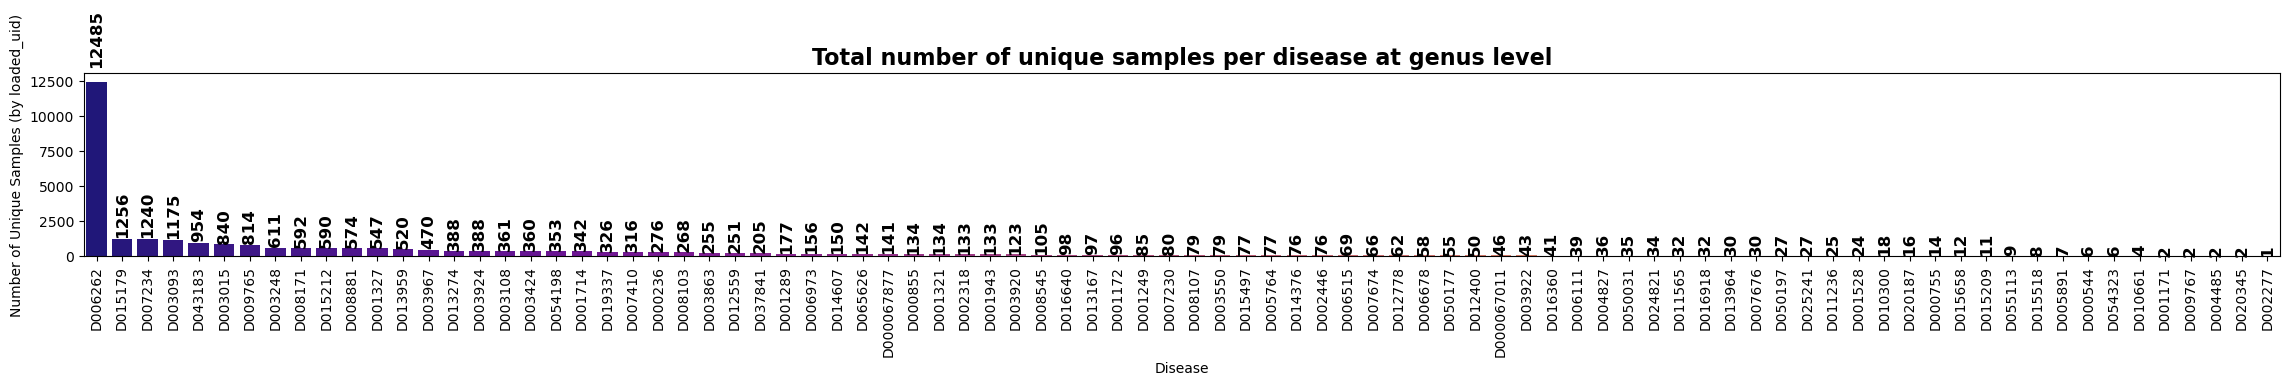

In [45]:
# Group and sort
unique_sample_counts = df_genus.groupby('disease')['loaded_uid'].nunique().reset_index()
unique_sample_counts.columns = ['disease', 'unique_sample_count']
unique_sample_counts = unique_sample_counts.sort_values('unique_sample_count', ascending=False)

# Plot
plt.figure(figsize=(23, 4))
ax = sns.barplot(
    data=unique_sample_counts,
    x='disease',
    y='unique_sample_count',
    hue='disease',
    dodge=False,
    palette='plasma',
    legend=False
)

# Add vertical count labels with proper spacing above the bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.08,  # Increased vertical offset (8% of height)
        f'{int(height)}',
        ha='center',
        va='bottom',
        rotation=90,
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Final formatting
plt.xticks(rotation=90)
plt.xlabel('Disease')
plt.ylabel('Number of Unique Samples (by loaded_uid)')
plt.title('Total number of unique samples per disease at genus level', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Descriptive Summary for Genus Level data
✅ Total unique samples before filtering: 26834
✅ Total diseases before filtering: 86
❌ Diseases removed (with <30 samples): 20
✅ Remaining diseases: 66
✅ Remaining unique samples after filtering: 26618


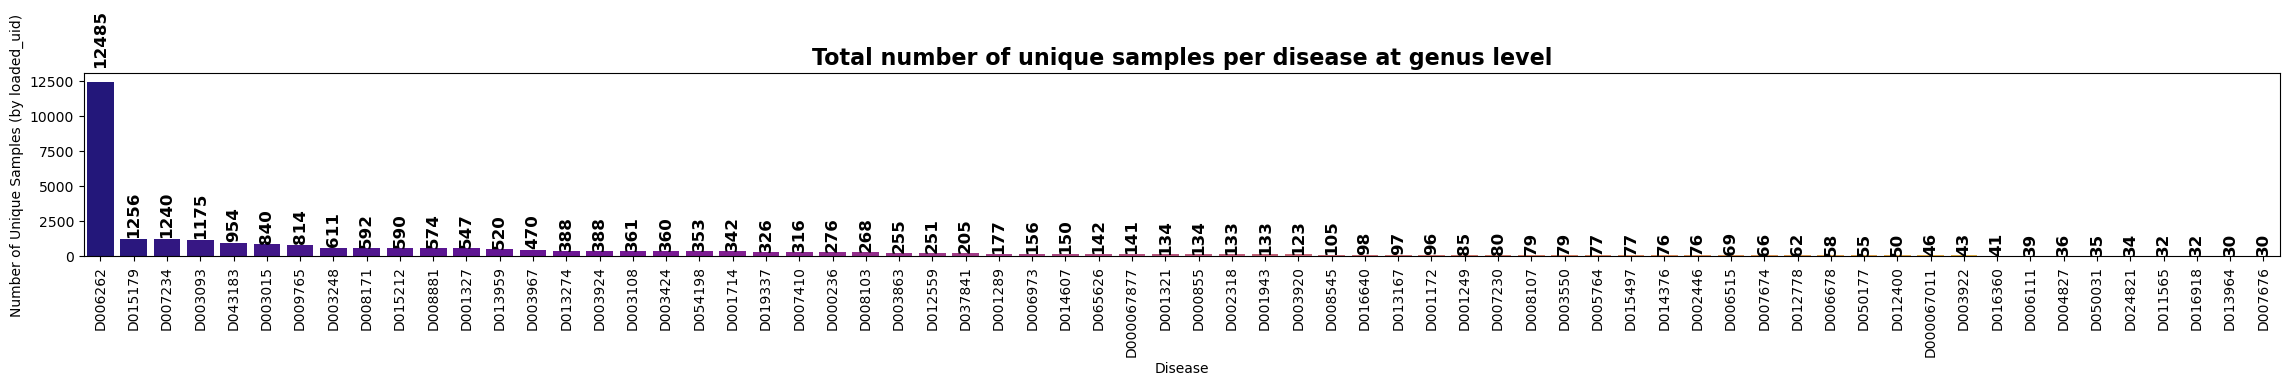

In [46]:
# GENUS FILTERING DISEASE LESS THAN 30 SAMPLES

# Step 0: Count total unique samples before filtering
total_unique_samples_before = df_genus['loaded_uid'].nunique()

# Step 1: Count number of unique samples per disease
sample_counts = df_genus.groupby('disease')['loaded_uid'].nunique()

# Step 2: Identify valid and removed diseases
valid_diseases = sample_counts[sample_counts >= 30].index
removed_diseases = sample_counts[sample_counts < 30].index

# Step 3: Filter the long-format table
df_genus_filtered = df_genus[df_genus['disease'].isin(valid_diseases)].copy()

# Step 4: Count total unique samples after filtering
total_unique_samples_after = df_genus_filtered['loaded_uid'].nunique()

# Step 5: Print summary
print("Descriptive Summary for Genus Level data")
print(f"✅ Total unique samples before filtering: {total_unique_samples_before}")
print(f"✅ Total diseases before filtering: {sample_counts.shape[0]}")
print(f"❌ Diseases removed (with <30 samples): {removed_diseases.shape[0]}")
print(f"✅ Remaining diseases: {len(valid_diseases)}")
print(f"✅ Remaining unique samples after filtering: {total_unique_samples_after}")

# Group and sort
unique_sample_counts = df_genus_filtered.groupby('disease')['loaded_uid'].nunique().reset_index()
unique_sample_counts.columns = ['disease', 'unique_sample_count']
unique_sample_counts = unique_sample_counts.sort_values('unique_sample_count', ascending=False)

# Plot
plt.figure(figsize=(23, 4))
ax = sns.barplot(
    data=unique_sample_counts,
    x='disease',
    y='unique_sample_count',
    hue='disease',
    dodge=False,
    palette='plasma',
    legend=False
)

# Add vertical count labels with proper spacing above the bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.08,  # Increased vertical offset (8% of height)
        f'{int(height)}',
        ha='center',
        va='bottom',
        rotation=90,
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Final formatting
plt.xticks(rotation=90)
plt.xlabel('Disease')
plt.ylabel('Number of Unique Samples (by loaded_uid)')
plt.title('Total number of unique samples per disease at genus level', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [47]:
# SHANNON INDEX CALCULATION
# Pivot the filtered DataFrame to create a wide-format table for genus
df_genus_pivoted = df_genus_filtered.pivot_table(
    index=['loaded_uid', 'disease'],
    columns='ncbi_taxon_id',
    values='relative_abundance',
    aggfunc='sum',
    fill_value=0
)

df_genus_pivoted['shannon'] = df_genus_pivoted.apply(shannon_index, axis=1)
df_genus_shannon = df_genus_pivoted['shannon'].reset_index()

___
SPECIES level

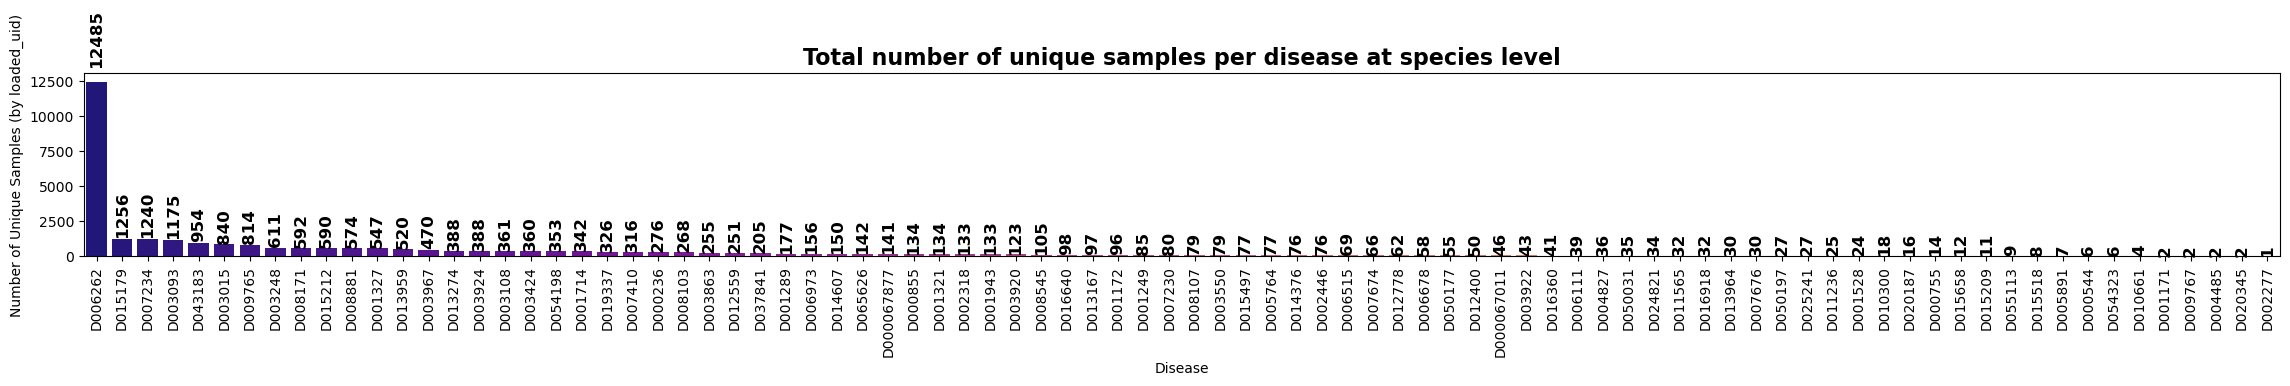

In [48]:
# Group and sort
unique_sample_counts = df_species.groupby('disease')['loaded_uid'].nunique().reset_index()
unique_sample_counts.columns = ['disease', 'unique_sample_count']
unique_sample_counts = unique_sample_counts.sort_values('unique_sample_count', ascending=False)

# Plot
plt.figure(figsize=(23, 4))
ax = sns.barplot(
    data=unique_sample_counts,
    x='disease',
    y='unique_sample_count',
    hue='disease',
    dodge=False,
    palette='plasma',
    legend=False
)

# Add vertical count labels with proper spacing above the bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.08,  # Increased vertical offset (8% of height)
        f'{int(height)}',
        ha='center',
        va='bottom',
        rotation=90,
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Final formatting
plt.xticks(rotation=90)
plt.xlabel('Disease')
plt.ylabel('Number of Unique Samples (by loaded_uid)')
plt.title('Total number of unique samples per disease at species level', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Descriptive Summary for Species Level data
✅ Total unique samples before filtering: 26834
✅ Total diseases before filtering: 86
❌ Diseases removed (with <60 samples): 20
✅ Remaining diseases: 66
✅ Remaining unique samples after filtering: 26618


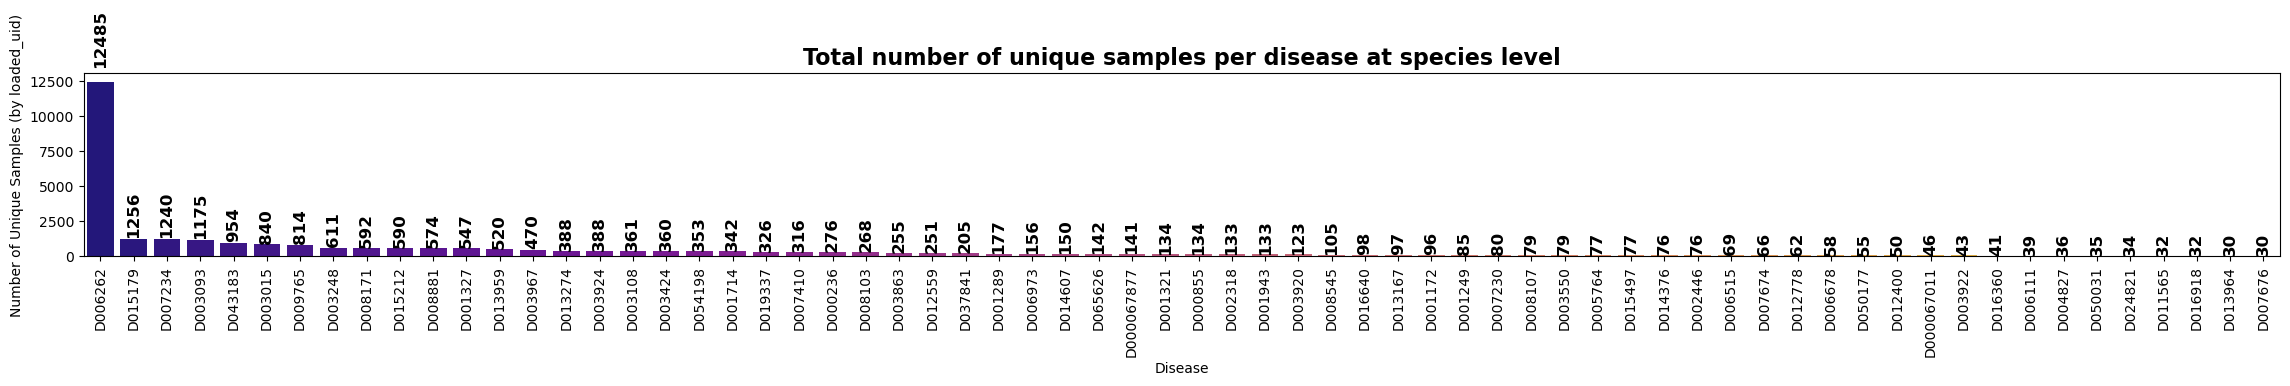

In [49]:
# SPECIES FILTERING DISEASE LESS THAN 30 SAMPLES

# Step 0: Count total unique samples before filtering
total_unique_samples_before = df_species['loaded_uid'].nunique()

# Step 1: Count number of unique samples per disease
sample_counts = df_species.groupby('disease')['loaded_uid'].nunique()

# Step 2: Identify valid and removed diseases
valid_diseases = sample_counts[sample_counts >= 30].index
removed_diseases = sample_counts[sample_counts < 30].index

# Step 3: Filter the long-format table
df_species_filtered = df_species[df_species['disease'].isin(valid_diseases)].copy()

# Step 4: Count total unique samples after filtering
total_unique_samples_after = df_species_filtered['loaded_uid'].nunique()

# Step 5: Print summary
print("Descriptive Summary for Species Level data")
print(f"✅ Total unique samples before filtering: {total_unique_samples_before}")
print(f"✅ Total diseases before filtering: {sample_counts.shape[0]}")
print(f"❌ Diseases removed (with <60 samples): {removed_diseases.shape[0]}")
print(f"✅ Remaining diseases: {len(valid_diseases)}")
print(f"✅ Remaining unique samples after filtering: {total_unique_samples_after}")

# Group and sort
unique_sample_counts = df_species_filtered.groupby('disease')['loaded_uid'].nunique().reset_index()
unique_sample_counts.columns = ['disease', 'unique_sample_count']
unique_sample_counts = unique_sample_counts.sort_values('unique_sample_count', ascending=False)

# Plot
plt.figure(figsize=(23, 4))
ax = sns.barplot(
    data=unique_sample_counts,
    x='disease',
    y='unique_sample_count',
    hue='disease',
    dodge=False,
    palette='plasma',
    legend=False
)

# Add vertical count labels with proper spacing above the bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.08,  # Increased vertical offset (8% of height)
        f'{int(height)}',
        ha='center',
        va='bottom',
        rotation=90,
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Final formatting
plt.xticks(rotation=90)
plt.xlabel('Disease')
plt.ylabel('Number of Unique Samples (by loaded_uid)')
plt.title('Total number of unique samples per disease at species level', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [50]:
# SHANNON INDEX CALCULATION
# Pivot the filtered DataFrame to create a wide-format table for species
df_species_pivoted = df_species_filtered.pivot_table(
    index=['loaded_uid', 'disease'],
    columns='ncbi_taxon_id',
    values='relative_abundance',
    aggfunc='sum',
    fill_value=0
)

df_species_pivoted['shannon'] = df_species_pivoted.apply(shannon_index, axis=1)
df_species_shannon = df_species_pivoted['shannon'].reset_index()

## <span style="color:teal"> __KRUSKAL WALLIS + DUNN POST HOC + FDR BENJAMINI HOCHBERG TEST__
<span style="color:teal"> We used the __Kruskal–Wallis H test__, a non-parametric alternative to ANOVA, to assess whether Shannon diversity differed significantly across disease groups compared to healthy controls. This test does not assume normality and is suitable for comparing distributions across multiple groups with unequal sample sizes. When the Kruskal–Wallis test indicated a significant overall difference, we performed post hoc pairwise comparisons using Dunn’s test to identify which specific diseases differed from the healthy group. To account for multiple testing across the large number of disease comparisons, we applied false discovery rate (FDR) correction to the p-values. This approach provides a statistically robust and interpretable framework for identifying diseases associated with significant shifts in microbial diversity.
___

In [51]:
# --------------------------------------------
# KRUSKAL–WALLIS AND DUNN POST HOC TESTS (GENUS LEVEL)
# --------------------------------------------

# Step 0: Ensure 'disease' column is string
df_genus_shannon['disease'] = df_genus_shannon['disease'].astype(str)

# Step 1: Define healthy group code
healthy_label = 'D006262'  # Replace if your healthy code is different

# Step 2: Filter only groups with ≥30 samples
eligible_groups = [
    group for _, group in df_genus_shannon.groupby('disease') if len(group) >= 30
]

# Step 3: Downsample every eligible group to exactly 30 samples
df_downsampled_genus = pd.concat([
    group.sample(n=30, random_state=42)
    for group in eligible_groups
])

# Tag level
df_downsampled_genus['level'] = 'genus'

# Step 4: Ensure healthy group is present after downsampling
if healthy_label not in df_downsampled_genus['disease'].unique():
    raise ValueError(f"Healthy label '{healthy_label}' not found in downsampled data.")

# Step 5: Perform Kruskal–Wallis test
groups_all = [
    group['shannon'].values
    for _, group in df_downsampled_genus.groupby('disease')
]
kw_stat, kw_pval = kruskal(*groups_all)

print(f"\nKruskal–Wallis H-test (Genus-level, downsampled)")
print(f"H-statistic = {kw_stat:.4f}")
print(f"P-value     = {kw_pval:.4e}")

# Step 6: Perform Dunn’s test if Kruskal–Wallis is significant
if kw_pval < 0.05:
    print("\nPerforming Dunn’s test with FDR correction (vs. Healthy)...")

    dunn_matrix_genus = sp.posthoc_dunn(
        df_downsampled_genus,
        val_col='shannon',
        group_col='disease',
        p_adjust='fdr_bh'
    )

    # Check healthy group is in the matrix
    if healthy_label not in dunn_matrix_genus.index or healthy_label not in dunn_matrix_genus.columns:
        raise KeyError(f"Healthy group '{healthy_label}' not found in Dunn matrix.")

    # Extract only comparisons vs Healthy (excluding diagonal)
    dunn_vs_healthy_genus = dunn_matrix_genus[healthy_label].drop(index=healthy_label, errors='ignore')
    dunn_vs_healthy_genus = dunn_vs_healthy_genus.sort_values()

    # Format output table
    df_dunn_vs_healthy_genus = pd.DataFrame({
        'Disease Code': dunn_vs_healthy_genus.index,
        'FDR-adjusted p-value': dunn_vs_healthy_genus.values,
    }).reset_index(drop=True)

    df_dunn_vs_healthy_genus['Significant (FDR < 0.05)'] = (
        df_dunn_vs_healthy_genus['FDR-adjusted p-value'] < 0.05
    )

    # Tag level
    df_dunn_vs_healthy_genus['level'] = 'genus'

    # Show final table
    print("\nDunn’s Post Hoc Test: Healthy vs Each Disease")
    display(df_dunn_vs_healthy_genus)

else:
    print("\nKruskal–Wallis not significant — skipping Dunn’s test.")
    df_dunn_vs_healthy_genus = None


Kruskal–Wallis H-test (Genus-level, downsampled)
H-statistic = 626.4688
P-value     = 9.2019e-93

Performing Dunn’s test with FDR correction (vs. Healthy)...

Dunn’s Post Hoc Test: Healthy vs Each Disease


,Disease Code,FDR-adjusted p-value,Significant (FDR < 0.05),level
0,D007234,2.460623e-08,True,genus
1,D001249,1.471729e-06,True,genus
2,D013274,2.943279e-06,True,genus
3,D013964,1.838407e-05,True,genus
4,D014376,1.035725e-04,True,genus
...,...,...,...,...
60,D008171,8.496490e-01,False,genus
61,D003248,9.015729e-01,False,genus
62,D003924,9.024621e-01,False,genus
63,D037841,9.486239e-01,False,genus


In [52]:
# --------------------------------------------
# KRUSKAL–WALLIS AND DUNN POST HOC TESTS (Species LEVEL)
# --------------------------------------------

# Step 0: Ensure 'disease' column is string
df_species_shannon['disease'] = df_species_shannon['disease'].astype(str)

# Step 1: Define healthy group code
healthy_label = 'D006262'  # Replace if your healthy code is different

# Step 2: Filter only groups with ≥30 samples
eligible_groups = [
    group for _, group in df_species_shannon.groupby('disease') if len(group) >= 30
]

# Step 3: Downsample every eligible group to exactly 30 samples
df_downsampled_species = pd.concat([
    group.sample(n=30, random_state=42)
    for group in eligible_groups
])

# Tag level
df_downsampled_species['level'] = 'species'

# Step 4: Ensure healthy group is present after downsampling
if healthy_label not in df_downsampled_species['disease'].unique():
    raise ValueError(f"Healthy label '{healthy_label}' not found in downsampled data.")

# Step 5: Perform Kruskal–Wallis test
groups_all = [
    group['shannon'].values
    for _, group in df_downsampled_species.groupby('disease')
]
kw_stat, kw_pval = kruskal(*groups_all)

print(f"\nKruskal–Wallis H-test (Species-level, downsampled)")
print(f"H-statistic = {kw_stat:.4f}")
print(f"P-value     = {kw_pval:.4e}")

# Step 6: Perform Dunn’s test if Kruskal–Wallis is significant
if kw_pval < 0.05:
    print("\nPerforming Dunn’s test with FDR correction (vs. Healthy)...")

    dunn_matrix_species = sp.posthoc_dunn(
        df_downsampled_species,
        val_col='shannon',
        group_col='disease',
        p_adjust='fdr_bh'
    )

    # Check healthy group is in the matrix
    if healthy_label not in dunn_matrix_species.index or healthy_label not in dunn_matrix_species.columns:
        raise KeyError(f"Healthy group '{healthy_label}' not found in Dunn matrix.")

    # Extract only comparisons vs Healthy (excluding diagonal)
    dunn_vs_healthy_species = dunn_matrix_species[healthy_label].drop(index=healthy_label, errors='ignore')
    dunn_vs_healthy_species = dunn_vs_healthy_species.sort_values()

    # Format output table
    df_dunn_vs_healthy_species = pd.DataFrame({
        'Disease Code': dunn_vs_healthy_species.index,
        'FDR-adjusted p-value': dunn_vs_healthy_species.values,
    }).reset_index(drop=True)

    df_dunn_vs_healthy_species['Significant (FDR < 0.05)'] = (
        df_dunn_vs_healthy_species['FDR-adjusted p-value'] < 0.05
    )

    # Tag level
    df_dunn_vs_healthy_species['level'] = 'species'

    # Show final table
    print("\nDunn’s Post Hoc Test: Healthy vs Each Disease")
    display(df_dunn_vs_healthy_species)

else:
    print("\nKruskal–Wallis not significant — skipping Dunn’s test.")
    df_dunn_vs_healthy_species = None



Kruskal–Wallis H-test (Species-level, downsampled)
H-statistic = 554.9787
P-value     = 6.8608e-79

Performing Dunn’s test with FDR correction (vs. Healthy)...

Dunn’s Post Hoc Test: Healthy vs Each Disease


,Disease Code,FDR-adjusted p-value,Significant (FDR < 0.05),level
0,D007234,6.087080e-09,True,species
1,D013274,1.610282e-06,True,species
2,D013964,1.339956e-05,True,species
3,D001249,2.343164e-04,True,species
4,D003015,1.161496e-03,True,species
...,...,...,...,...
60,D004827,9.580725e-01,False,species
61,D003093,9.706878e-01,False,species
62,D016360,9.759235e-01,False,species
63,D008171,9.835233e-01,False,species


## <span style="color:teal"> __BOX WHISKER PLOT WITH KRUSKAL WALLIS + DUNN POST HOC + FDR BENJAMINI HOCHBERG TEST__
<span style="color:teal"> 


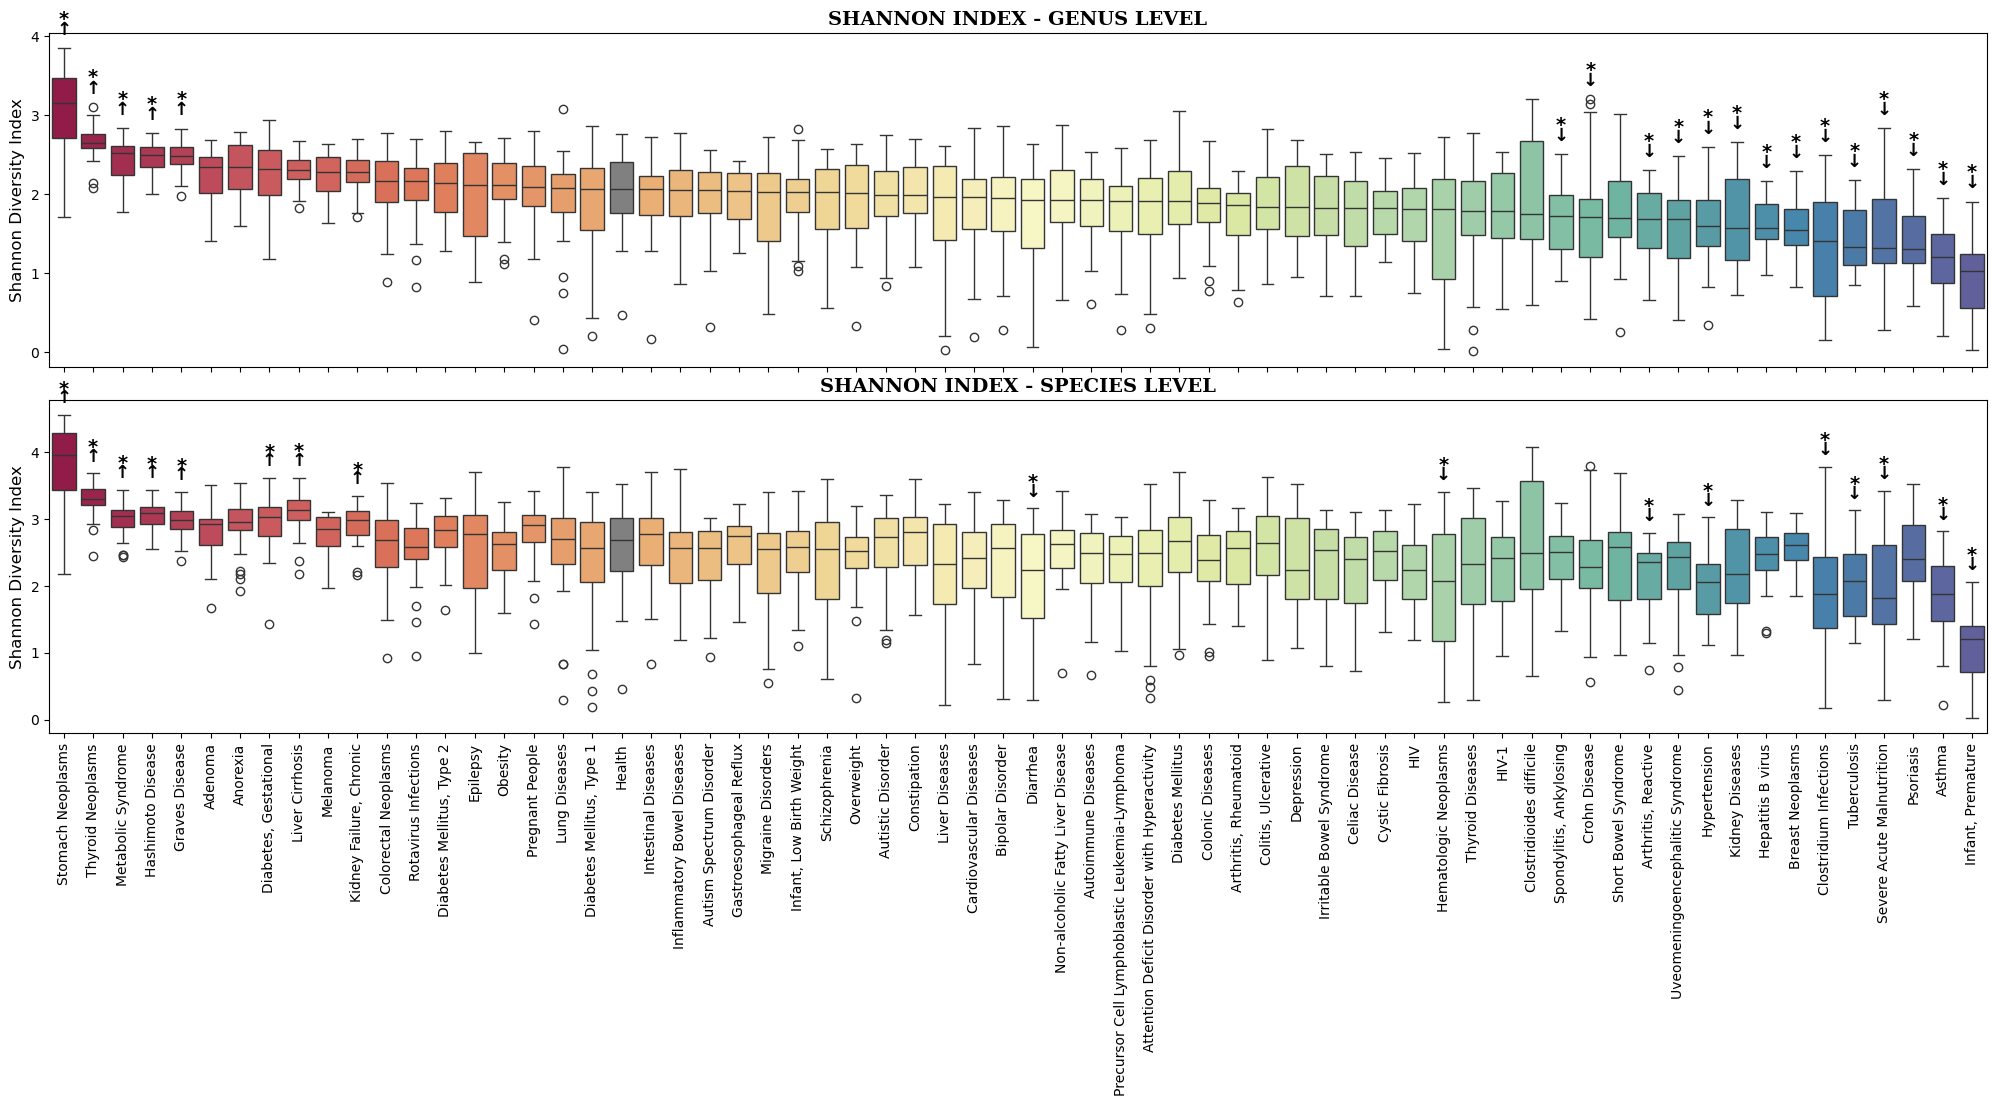

In [53]:
# --------------------------
# Define healthy label
# --------------------------
healthy_label = 'D006262'
healthy_name = disease_dict.get(healthy_label, 'Healthy')

# --------------------------
# Prepare function to generate plot data
# --------------------------
def prepare_plot_data(df_downsampled, df_dunn_vs_healthy):
    df_plot = df_downsampled.copy()
    df_plot['disease_name'] = df_plot['disease'].map(disease_dict)

    if df_dunn_vs_healthy is not None:
        significant_diseases = df_dunn_vs_healthy.query("`Significant (FDR < 0.05)`")['Disease Code'].tolist()
        significant_names = [disease_dict.get(code, code) for code in significant_diseases]
    else:
        significant_names = []

    df_plot['significant'] = df_plot['disease_name'].isin(significant_names)

    ordered_names = (
        df_plot.groupby("disease_name")["shannon"]
        .median()
        .sort_values(ascending=False)
        .index
    )

    palette = sns.color_palette("Spectral", n_colors=len(ordered_names) - 1)
    color_dict = {}
    palette_idx = 0
    for name in ordered_names:
        if name == healthy_name:
            color_dict[name] = 'grey'
        else:
            color_dict[name] = palette[palette_idx]
            palette_idx += 1

    return df_plot, ordered_names, color_dict, significant_names

# --------------------------
# Prepare genus-level data
# --------------------------
df_plot_genus, ordered_names_genus, color_dict_genus, significant_genus = prepare_plot_data(
    df_downsampled_genus, df_dunn_vs_healthy_genus
)

# --------------------------
# Prepare species-level data, reuse genus order & colors
# --------------------------
df_plot_species, _, _, significant_species = prepare_plot_data(
    df_downsampled_species, df_dunn_vs_healthy_species
)
ordered_names_species = ordered_names_genus
color_dict_species = color_dict_genus

# --------------------------
# Healthy medians for arrow direction
# --------------------------
healthy_median_genus = df_plot_genus[df_plot_genus['disease'] == healthy_label]['shannon'].median()
healthy_median_species = df_plot_species[df_plot_species['disease'] == healthy_label]['shannon'].median()

# --------------------------
# Create subplots with shared x-axis
# --------------------------
fig, axes = plt.subplots(2, 1, figsize=(25, 10), sharex=True)

# === GENUS LEVEL PLOT ===
sns.boxplot(
    data=df_plot_genus,
    x="disease_name",
    y="shannon",
    order=ordered_names_genus,
    hue="disease_name",
    hue_order=ordered_names_genus,
    palette=color_dict_genus,
    dodge=False,
    legend=False,
    ax=axes[0],
)


axes[0].set_title("SHANNON INDEX - GENUS LEVEL", fontsize=14, fontweight='bold', fontname='serif')
axes[0].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[0].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
axes[0].tick_params(axis='x', rotation=90, labelbottom=False)

for i, name in enumerate(ordered_names_genus):
    if name in significant_genus and name != healthy_name:
        max_val = df_plot_genus[df_plot_genus['disease_name'] == name]['shannon'].max()
        # asterisk
        axes[0].text(i, max_val + 0.25, "*", ha='center', va='bottom',
                     fontsize=14, fontweight='bold', color='black')
        # arrow: up if disease median > healthy median, else down
        med_val = df_plot_genus[df_plot_genus['disease_name'] == name]['shannon'].median()
        arrow = "↑" if med_val > healthy_median_genus else "↓"
        axes[0].text(i, max_val + 0.12, arrow, ha='center', va='bottom',
                     fontsize=13, fontweight='bold', color='black')

# === SPECIES LEVEL PLOT ===
sns.boxplot(
    data=df_plot_species,
    x="disease_name",
    y="shannon",
    order=ordered_names_species,
    hue="disease_name",
    hue_order=ordered_names_species,
    palette=color_dict_species,
    dodge=False,
    legend=False,
    ax=axes[1],
)

axes[1].set_title("SHANNON INDEX - SPECIES LEVEL", fontsize=14, fontweight='bold', fontname='serif')
axes[1].set_xlabel(None)
axes[1].set_ylabel("Shannon Diversity Index", fontsize=12)
axes[1].tick_params(axis='x', rotation=90)
axes[1].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

for i, name in enumerate(ordered_names_species):
    if name in significant_species and name != healthy_name:
        max_val = df_plot_species[df_plot_species['disease_name'] == name]['shannon'].max()
        # asterisk
        axes[1].text(i, max_val + 0.25, "*", ha='center', va='bottom',
                     fontsize=14, fontweight='bold', color='black')
        # arrow direction vs healthy
        med_val = df_plot_species[df_plot_species['disease_name'] == name]['shannon'].median()
        arrow = "↑" if med_val > healthy_median_species else "↓"
        axes[1].text(i, max_val + 0.12, arrow, ha='center', va='bottom',
                     fontsize=13, fontweight='bold', color='black')

# --------------------------
# Final formatting
# --------------------------
plt.subplots_adjust(hspace=0.1, bottom=0.18)
plt.show()


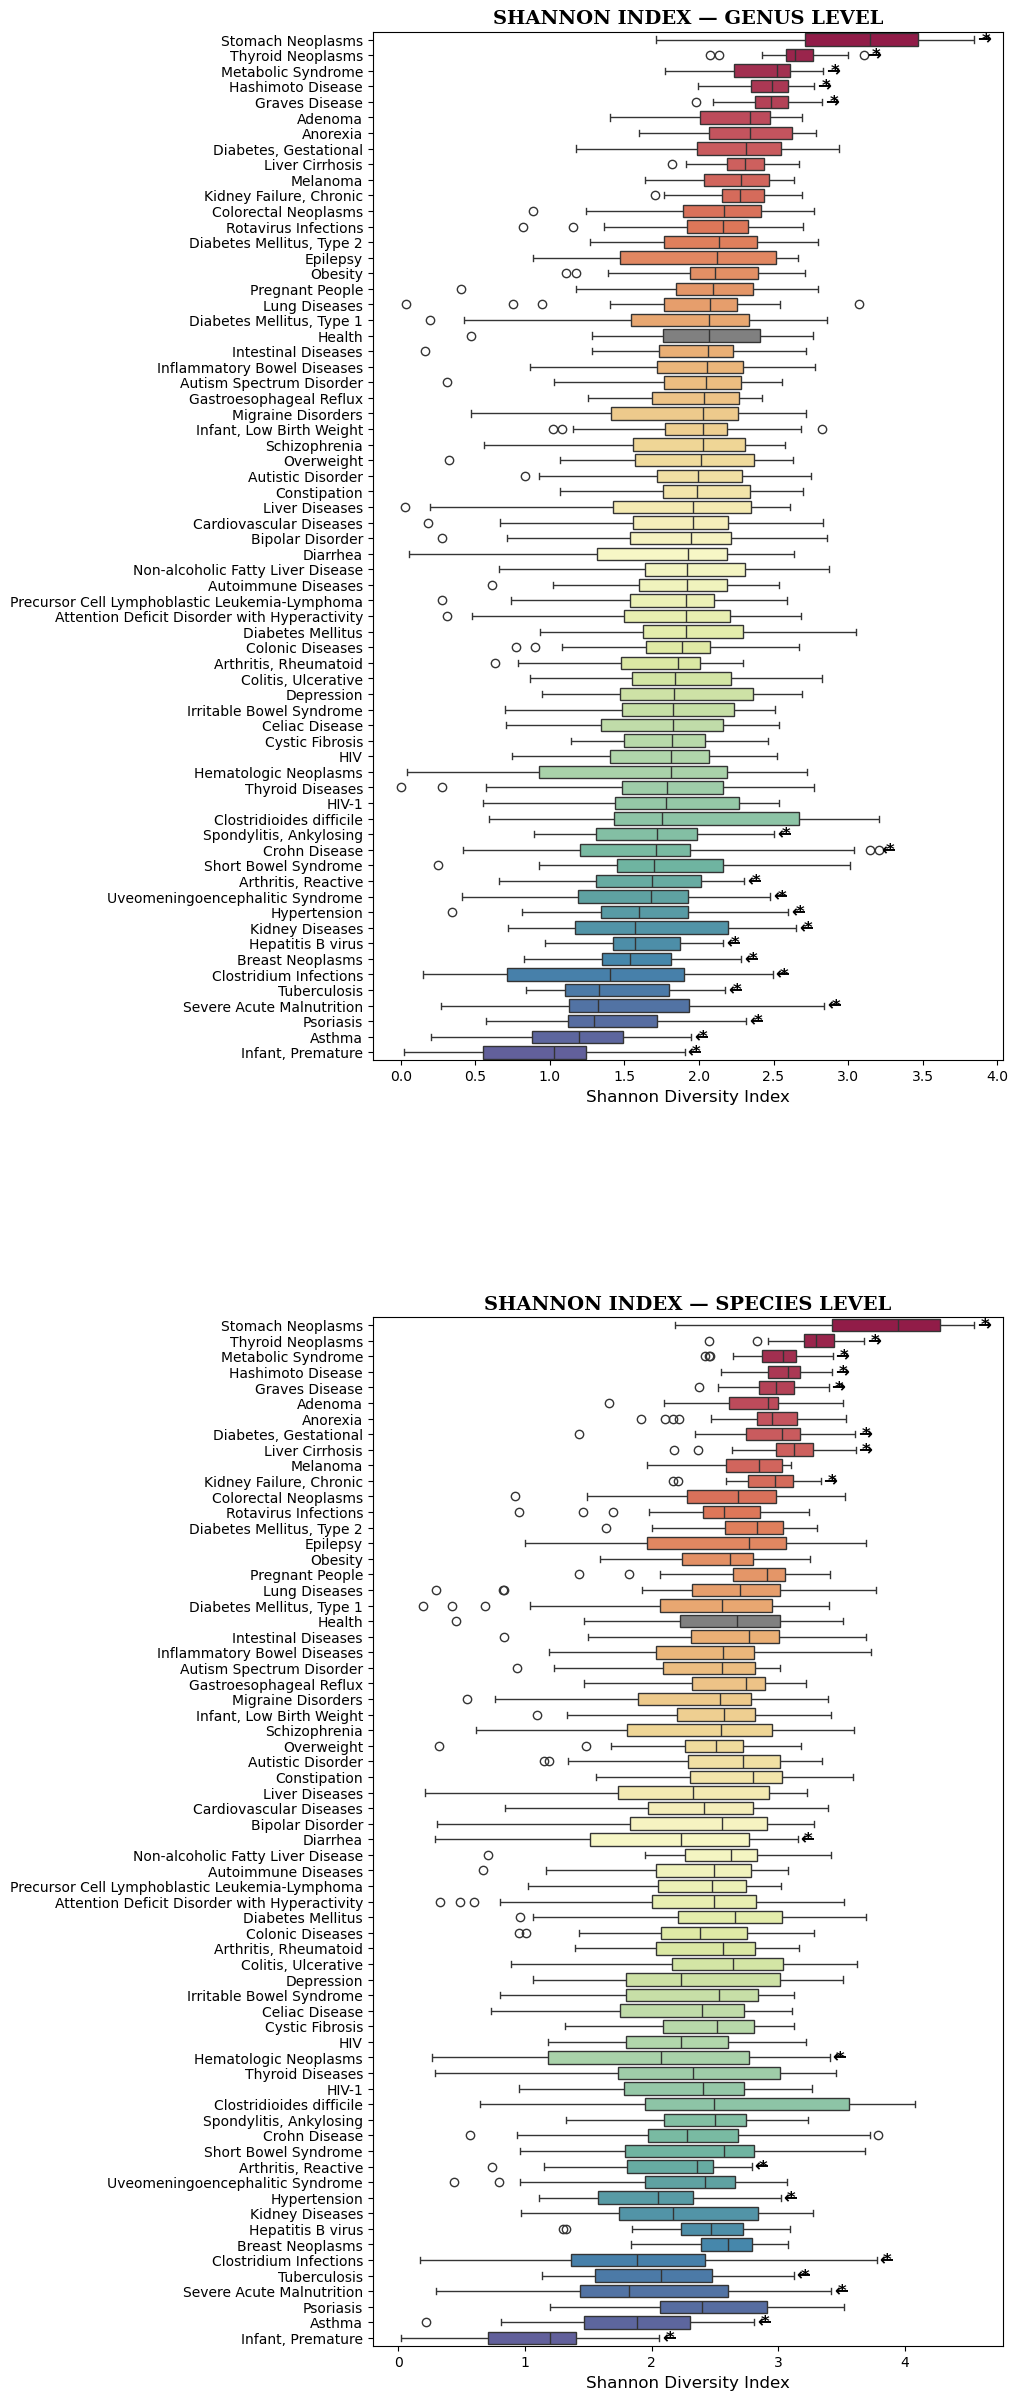

In [55]:
# --------------------------
# Healthy medians for arrow direction
# --------------------------
healthy_median_genus   = df_plot_genus[df_plot_genus['disease'] == healthy_label]['shannon'].median()
healthy_median_species = df_plot_species[df_plot_species['disease'] == healthy_label]['shannon'].median()

# --------------------------
# Create subplots with shared y-axis (vertical categories)
# --------------------------
fig, axes = plt.subplots(2, 1, figsize=(10, 26), sharex=False, sharey=True)

# === GENUS LEVEL (horizontal boxes) ===
sns.boxplot(
    data=df_plot_genus,
    y="disease_name",
    x="shannon",
    order=ordered_names_genus,          # vertical order down the page
    hue="disease_name",
    hue_order=ordered_names_genus,
    palette=color_dict_genus,
    dodge=False,
    legend=False,
    ax=axes[0],
)

axes[0].set_title("SHANNON INDEX — GENUS LEVEL", fontsize=14, fontweight='bold', fontname='serif')
axes[0].set_xlabel("Shannon Diversity Index", fontsize=12)
axes[0].set_ylabel(None)

# annotate significance + direction (→ higher than healthy, ← lower)
for i, name in enumerate(ordered_names_genus):
    if name in significant_genus and name != healthy_name:
        row = df_plot_genus[df_plot_genus['disease_name'] == name]['shannon']
        max_val = row.max()
        med_val = row.median()
        arrow = "→" if med_val > healthy_median_genus else "←"
        axes[0].text(max_val + 0.05, i, "*", va='center', ha='left',
                     fontsize=12, fontweight='bold', color='black')
        axes[0].text(max_val + 0.02, i, arrow, va='center', ha='left',
                     fontsize=12, fontweight='bold', color='black')

# === SPECIES LEVEL (horizontal boxes), same order & colors ===
sns.boxplot(
    data=df_plot_species,
    y="disease_name",
    x="shannon",
    order=ordered_names_species,
    hue="disease_name",
    hue_order=ordered_names_species,
    palette=color_dict_species,
    dodge=False,
    legend=False,
    ax=axes[1],
)

axes[1].set_title("SHANNON INDEX — SPECIES LEVEL", fontsize=14, fontweight='bold', fontname='serif')
axes[1].set_xlabel("Shannon Diversity Index", fontsize=12)
axes[1].set_ylabel(None)

for i, name in enumerate(ordered_names_species):
    if name in significant_species and name != healthy_name:
        row = df_plot_species[df_plot_species['disease_name'] == name]['shannon']
        max_val = row.max()
        med_val = row.median()
        arrow = "→" if med_val > healthy_median_species else "←"
        axes[1].text(max_val + 0.05, i, "*", va='center', ha='left',
                     fontsize=12, fontweight='bold', color='black')
        axes[1].text(max_val + 0.02, i, arrow, va='center', ha='left',
                     fontsize=12, fontweight='bold', color='black')

# --------------------------
# Final formatting
# --------------------------
for ax in axes:
    if ax.legend_:  # just in case seaborn adds one
        ax.legend_.remove()

plt.subplots_adjust(left=0.35, hspace=0.25, bottom=0.06, top=0.95, right=0.98)
plt.show()
